In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [4]:
train_df = pd.read_csv('train.csv')

# set up for further filtering
train_df['NameLength'] = train_df['Name'].str.len()
train_df['Cabin'] = train_df['Cabin'].astype(str)
train_df['Cabin'] = train_df['Cabin'].str[0] + train_df['Cabin'].str[-1]
train_df['total spending'] = train_df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
train_df['VIP'] = train_df['VIP'].fillna(False).astype(int)
train_df['CryoSleep'] = train_df['CryoSleep'].fillna(False).astype(int)

# needed to calculate the distribution of positives to sort catagorical features
transported_true = train_df[train_df['Transported'] == True]

# sort homeplanet catagories by True values percentages
counts = train_df['HomePlanet'].value_counts()
transported_counts = transported_true.groupby('HomePlanet').size()
percentages = transported_counts/counts
homeplanet_map = percentages.sort_values(ascending=False)
planet_map = {planet: rank for rank, planet in enumerate(homeplanet_map.index)}
train_df['HomePlanet'] = train_df['HomePlanet'].map(planet_map)


# sort destination catagories by True values percentages
Destcounts = train_df['Destination'].value_counts()
transDest_counts = transported_true.groupby('Destination').size()
percent_vals = transDest_counts/Destcounts
dest_map = percent_vals.sort_values(ascending=False)
d_map = {planet: rank for rank, planet in enumerate(dest_map.index)}
train_df['Destination'] = train_df['Destination'].map(d_map)

# sort Cabin catagories by True values percentages
# This does not need to be divided by counts as in my previous notebook it is 
# shown that there is less than a 1% differance in size of groups
cabin_counts = train_df[train_df['Transported'] == True].groupby('Cabin').size()
sorted_cabins = cabin_counts.sort_values(ascending=False).index
cabin_mapping = {cabin: rank for rank, cabin in enumerate(sorted_cabins)}
train_df['Cabin_ordinal'] = train_df['Cabin'].map(cabin_mapping).fillna(-1).astype(int)


# Targets
targets = train_df['Transported']


#drop unused Catagories
filtered_X = train_df[['HomePlanet', 'CryoSleep', 'Age','VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','NameLength', 'total spending', 'Cabin_ordinal']]

filtered_X


,HomePlanet,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,NameLength,total spending,Cabin_ordinal
0,0.0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,6
1,2.0,0,24.0,0,109.0,9.0,25.0,549.0,44.0,12.0,736.0,1
2,0.0,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,13.0,10383.0,13
3,0.0,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,12.0,5176.0,13
4,2.0,0,16.0,0,303.0,70.0,151.0,565.0,2.0,17.0,1091.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0.0,0,41.0,1,0.0,6819.0,0.0,1643.0,74.0,17.0,8536.0,14
8689,2.0,1,18.0,0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0
8690,2.0,0,26.0,0,0.0,0.0,1872.0,1.0,0.0,12.0,1873.0,0
8691,0.0,0,32.0,0,0.0,1049.0,0.0,353.0,3235.0,16.0,4637.0,8


In [8]:
filtered_X = filtered_X.fillna(filtered_X.median())

In [11]:
nan_rows = filtered_X.isna().any(axis=1).sum()
print(f"Total rows with at least one NaN: {nan_rows}")


Total rows with at least one NaN: 0


In [62]:
X_train, X_test, y_train, y_test = train_test_split(filtered_X, targets, test_size=0.15, stratify=targets, random_state=1)
pipe = make_pipeline(StandardScaler(), XGBClassifier(random_state = 1,max_depth = 4,subsample=0.8,min_child_weight = 2,learning_rate = 0.05,eval_metric="logloss"))

In [63]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


In [64]:
kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe.fit(X_train.iloc[train], y_train.iloc[train])
    score = pipe.score(X_train.iloc[test], y_train.iloc[test])
    scores.append(score)
    print(f'Fold: {k+1:02d}, Class dist: {np.bincount(y_train[train])}, Acc: {score:.3f}')

mean_acc = np.mean(scores)
std_acc = np.std(scores)
print(f'\n overall accuracy: {mean_acc:.3f} +/- {std_acc:.3f}')

Fold: 01, Class dist: [3301 3349], Acc: 0.793
Fold: 02, Class dist: [3301 3349], Acc: 0.805
Fold: 03, Class dist: [3301 3349], Acc: 0.766
Fold: 04, Class dist: [3301 3349], Acc: 0.806
Fold: 05, Class dist: [3301 3349], Acc: 0.786
Fold: 06, Class dist: [3301 3349], Acc: 0.792
Fold: 07, Class dist: [3301 3349], Acc: 0.797
Fold: 08, Class dist: [3301 3349], Acc: 0.797
Fold: 09, Class dist: [3302 3348], Acc: 0.811
Fold: 10, Class dist: [3302 3349], Acc: 0.814

 overall accuracy: 0.797 +/- 0.013


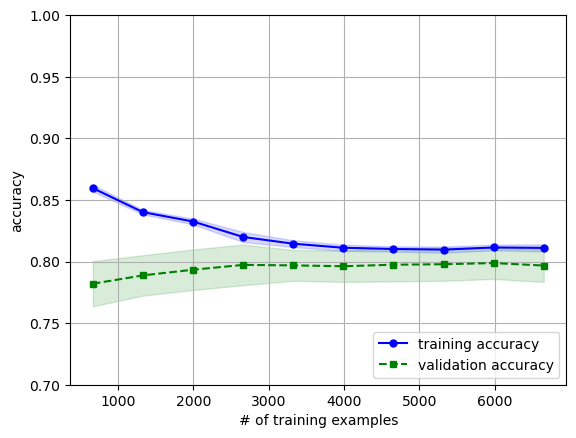

In [65]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe, X=X_train, y = y_train, train_sizes=np.linspace(0.1,1.0,10), cv = 10, n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean+train_std,train_mean-train_std, alpha = 0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green',linestyle = '--' ,marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean+test_std,test_mean-test_std, alpha = 0.15, color='green')

plt.grid()
plt.xlabel('# of training examples')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim([0.7,1])
plt.show()

orginally with no params showed high degree of over fitting and variance CV was not the issue as both higher and lower numbers show the same convergence with a high differance however adding these params did not change the validation accuracy but affected the training accuracy to look like the image above max_depth=4,subsample=0.8,eval_metric="logloss"

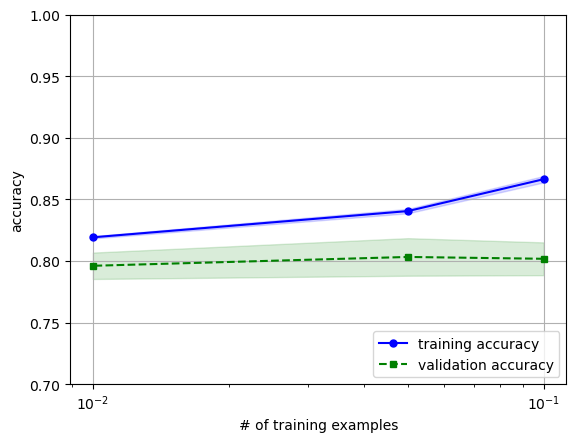

In [57]:
from sklearn.model_selection import validation_curve
param_range = [0.1,0.05,0.01]
train_scores2, test_scores2 = validation_curve(estimator=pipe,X = X_train, y = y_train, param_name='xgbclassifier__learning_rate', param_range=param_range, cv =10)

train_mean2 = np.mean(train_scores2, axis=1)
train_std2 = np.std(train_scores2, axis=1)
test_mean2 = np.mean(test_scores2, axis=1)
test_std2 = np.std(test_scores2, axis=1)

plt.plot(param_range, train_mean2, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean2+train_std2,train_mean2-train_std2, alpha = 0.15, color='blue')

plt.plot(param_range, test_mean2, color='green',linestyle = '--' ,marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean2+test_std2,test_mean2-test_std2, alpha = 0.15, color='green')

plt.grid()
plt.xscale('log')
plt.xlabel('# of training examples')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim([0.7,1])
plt.show()